###Importing Libraries

In [ ]:
# Import required libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

###Drive Connection

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


###Building Spark Session

In [ ]:
# Initialize Spark Session with adequate memory
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

###Loading and Reading Datasets

In [ ]:
# List of parquet files for July-December 2016
file_paths = [
    '/content/drive/My Drive/Big_Data/Project 3/yellow_tripdata_2016-07.parquet',
    '/content/drive/My Drive/Big_Data/Project 3/yellow_tripdata_2016-08.parquet',
    '/content/drive/My Drive/Big_Data/Project 3/yellow_tripdata_2016-09.parquet',
    '/content/drive/My Drive/Big_Data/Project 3/yellow_tripdata_2016-10.parquet',
    '/content/drive/My Drive/Big_Data/Project 3/yellow_tripdata_2016-11.parquet',
    '/content/drive/My Drive/Big_Data/Project 3/yellow_tripdata_2016-12.parquet'
]

# Load the first file to examine schema
sample_df = spark.read.parquet(file_paths[0])

# Display schema
print("Dataset Schema:")
sample_df.printSchema()


Dataset Schema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [ ]:
# Load all files and union them
def load_all_data(file_paths):
    df = spark.read.parquet(file_paths[0])
    for path in file_paths[1:]:
        temp_df = spark.read.parquet(path)
        df = df.unionAll(temp_df)
    return df

# Load all data
df = load_all_data(file_paths)

### Basic data cleaning and feature engineering


In [ ]:
def preprocess_data(df):
    # Convert timestamps
    df = df.withColumn("pickup_datetime", F.to_timestamp("tpep_pickup_datetime"))
    df = df.withColumn("dropoff_datetime", F.to_timestamp("tpep_dropoff_datetime"))

    # Calculate trip duration in minutes
    df = df.withColumn("trip_duration",
        F.round((F.unix_timestamp("dropoff_datetime") - F.unix_timestamp("pickup_datetime")) / 60, 2))

    # Extract time-based features
    df = df.withColumn("pickup_hour", F.hour("pickup_datetime"))
    df = df.withColumn("pickup_day", F.dayofweek("pickup_datetime"))
    df = df.withColumn("pickup_month", F.month("pickup_datetime"))

    # Remove obvious outliers
    df = df.filter(
        (F.col("trip_distance") > 0) &
        (F.col("trip_distance") < 100) &  # Remove unreasonably long trips
        (F.col("fare_amount") > 0) &
        (F.col("fare_amount") < 1000) &  # Remove unreasonably high fares
        (F.col("trip_duration") > 0) &
        (F.col("trip_duration") < 180)    # Remove trips longer than 3 hours
    )

    return df

# Preprocess the data
cleaned_df = preprocess_data(df)

In [ ]:

# Basic statistics and data quality checks
def perform_data_quality_checks(df):
    print("\nDataset Overview:")
    print(f"Total number of records: {df.count():,}")

    # Count null values
    print("\nNull Values Count:")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

    # Payment type distribution
    print("\nPayment Type Distribution:")
    df.groupBy("payment_type").count().orderBy("payment_type").show()

    # RateCodeID distribution
    print("\nRate Code Distribution:")
    df.groupBy("RatecodeID").count().orderBy("RatecodeID").show()

    # Basic statistics for numerical columns
    print("\nBasic Statistics for Numerical Columns:")
    df.select("trip_distance", "fare_amount", "trip_duration", "tip_amount",
              "total_amount", "passenger_count") \
      .summary("count", "mean", "stddev", "min", "max") \
      .show()


###Exploratory Data Analysis

Starting Data Analysis...

Dataset Overview:
Total number of records: 61,240,245

Null Values Count:
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+----------------+-------------+-----------+----------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_datetime|dropoff_datetime|trip_duration|pickup_hour|pickup_day|pickup_month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+--

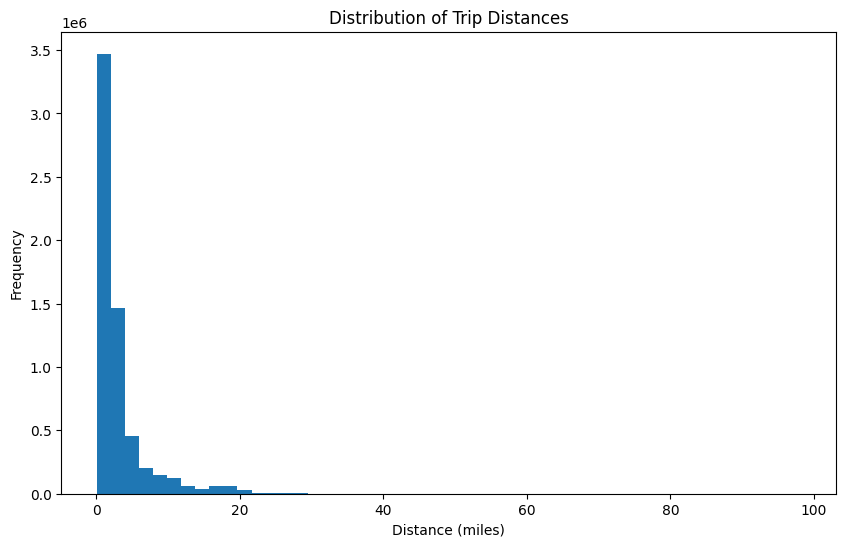

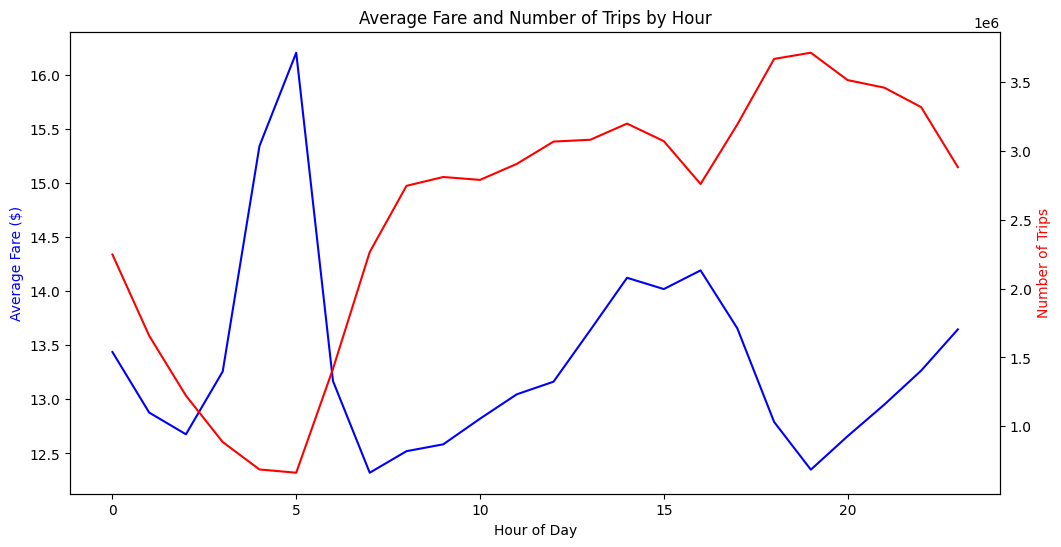

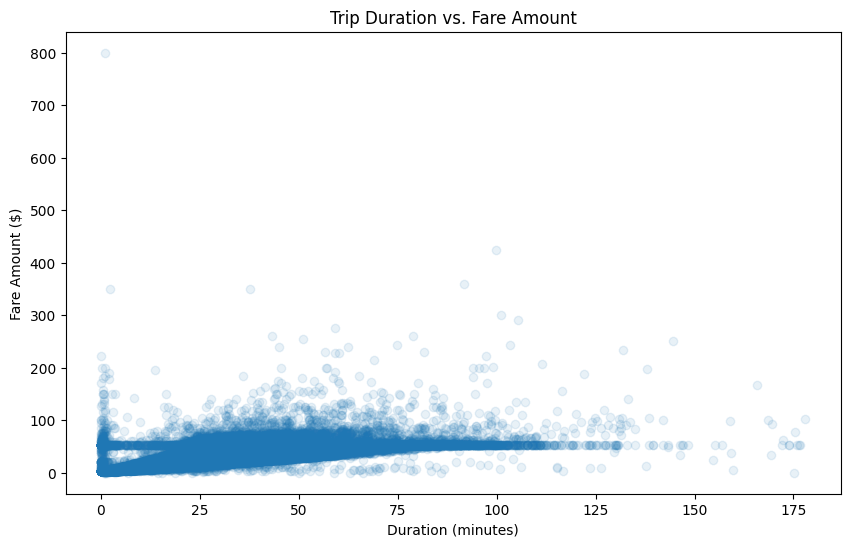

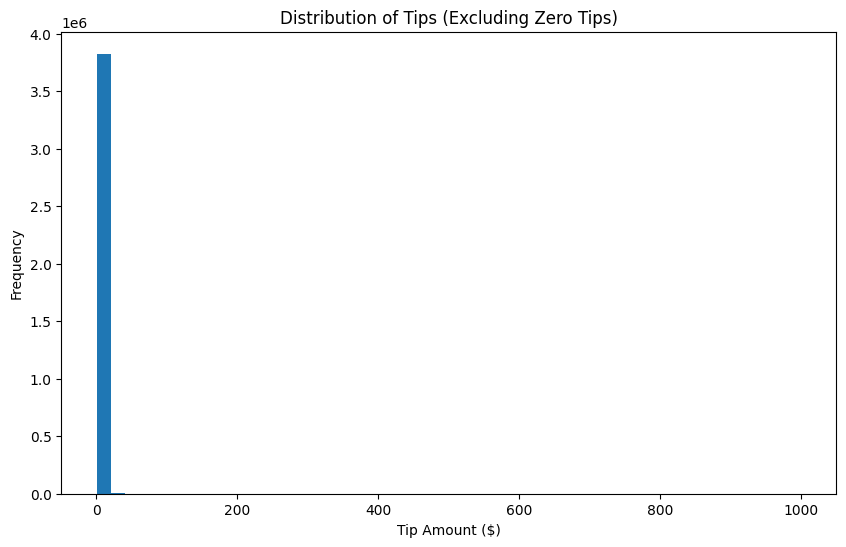

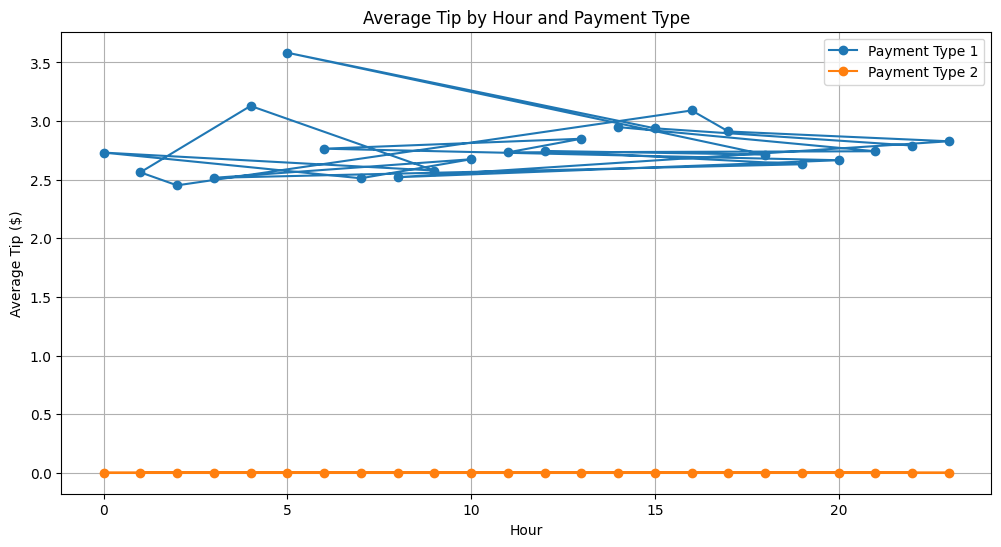


Sample of Processed Data:
+-------------------+-------------------+-------------+-----------+----------+-------------+-----------+----------+------------+------------+------------+------------+
|    pickup_datetime|   dropoff_datetime|trip_distance|fare_amount|tip_amount|trip_duration|pickup_hour|pickup_day|pickup_month|PULocationID|DOLocationID|payment_type|
+-------------------+-------------------+-------------+-----------+----------+-------------+-----------+----------+------------+------------+------------+------------+
|2016-07-01 00:17:36|2016-07-01 00:26:31|          1.6|        8.0|      1.85|         8.92|          0|         6|           7|          79|         186|           1|
|2016-07-01 00:20:12|2016-07-01 00:45:10|          5.0|       21.5|       0.0|        24.97|          0|         6|           7|         162|          83|           2|
|2016-07-01 00:30:15|2016-07-01 01:03:02|          5.7|       20.5|      4.35|        32.78|          0|         6|           7|     

In [ ]:
# Perform EDA
def perform_eda(df):
    # 1. Distribution of trip distances
    trip_dist_pd = df.select("trip_distance").sample(False, 0.1).toPandas()
    plt.figure(figsize=(10, 6))
    plt.hist(trip_dist_pd["trip_distance"], bins=50)
    plt.title("Distribution of Trip Distances")
    plt.xlabel("Distance (miles)")
    plt.ylabel("Frequency")
    plt.show()

    # 2. Average fare by hour of day
    hourly_fares = df.groupBy("pickup_hour") \
                    .agg(F.avg("fare_amount").alias("avg_fare"),
                         F.count("*").alias("num_trips")) \
                    .orderBy("pickup_hour") \
                    .toPandas()

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.plot(hourly_fares["pickup_hour"], hourly_fares["avg_fare"], 'b-', label='Avg Fare')
    ax2.plot(hourly_fares["pickup_hour"], hourly_fares["num_trips"], 'r-', label='Num Trips')
    ax1.set_xlabel("Hour of Day")
    ax1.set_ylabel("Average Fare ($)", color='b')
    ax2.set_ylabel("Number of Trips", color='r')
    plt.title("Average Fare and Number of Trips by Hour")
    plt.show()

    # 3. Trip duration vs. fare amount
    sample_df = df.select("trip_duration", "fare_amount") \
                 .sample(False, 0.01).toPandas()
    plt.figure(figsize=(10, 6))
    plt.scatter(sample_df["trip_duration"], sample_df["fare_amount"], alpha=0.1)
    plt.title("Trip Duration vs. Fare Amount")
    plt.xlabel("Duration (minutes)")
    plt.ylabel("Fare Amount ($)")
    plt.show()

    # 4. Distribution of tips
    tips_pd = df.filter(F.col("tip_amount") > 0) \
                .select("tip_amount") \
                .sample(False, 0.1) \
                .toPandas()
    plt.figure(figsize=(10, 6))
    plt.hist(tips_pd["tip_amount"], bins=50)
    plt.title("Distribution of Tips (Excluding Zero Tips)")
    plt.xlabel("Tip Amount ($)")
    plt.ylabel("Frequency")
    plt.show()

    # 5. Average tips by hour and payment type
    hourly_tips = df.filter(F.col("payment_type").isin([1, 2])) \
                   .groupBy("pickup_hour", "payment_type") \
                   .agg(F.avg("tip_amount").alias("avg_tip")) \
                   .toPandas()

    plt.figure(figsize=(12, 6))
    for payment_type in [1, 2]:  # 1: Credit card, 2: Cash
        data = hourly_tips[hourly_tips["payment_type"] == payment_type]
        plt.plot(data["pickup_hour"], data["avg_tip"],
                label=f"Payment Type {payment_type}", marker='o')
    plt.title("Average Tip by Hour and Payment Type")
    plt.xlabel("Hour")
    plt.ylabel("Average Tip ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate summary statistics by month
def generate_monthly_stats(df):
    print("\nMonthly Statistics:")
    monthly_stats = df.groupBy("pickup_month").agg(
        F.count("*").alias("total_trips"),
        F.round(F.avg("fare_amount"), 2).alias("avg_fare"),
        F.round(F.avg("trip_distance"), 2).alias("avg_distance"),
        F.round(F.avg("tip_amount"), 2).alias("avg_tip"),
        F.round(F.avg("trip_duration"), 2).alias("avg_duration"),
        F.round(F.avg("passenger_count"), 2).alias("avg_passengers")
    ).orderBy("pickup_month")

    monthly_stats.show()

# Execute all analysis functions
print("Starting Data Analysis...")
perform_data_quality_checks(cleaned_df)
generate_monthly_stats(cleaned_df)
perform_eda(cleaned_df)

# Save processed data for future use
cleaned_df.write.mode("overwrite").parquet("/content/drive/My Drive/Big_Data/Project 3/processed_taxi_data")

# Display sample of final processed data
print("\nSample of Processed Data:")
cleaned_df.select(
    "pickup_datetime", "dropoff_datetime", "trip_distance",
    "fare_amount", "tip_amount", "trip_duration",
    "pickup_hour", "pickup_day", "pickup_month",
    "PULocationID", "DOLocationID", "payment_type"
).show(5)

###Data Quality Assessment

In [ ]:
# Data Quality Assessment Functions
def assess_location_data_quality(df):
    """Assess quality of location data for spatial analysis"""
    location_stats = df.agg(
        F.count("PULocationID").alias("total_records"),
        F.countDistinct("PULocationID").alias("unique_pickup_locations"),
        F.countDistinct("DOLocationID").alias("unique_dropoff_locations"),
        F.count(F.when(F.col("PULocationID").isNull(), True)).alias("null_pickups"),
        F.count(F.when(F.col("DOLocationID").isNull(), True)).alias("null_dropoffs")
    ).toPandas()

    return location_stats

def assess_temporal_coverage(df):
    """Assess temporal coverage and consistency"""
    return df.agg(
        F.min("pickup_datetime").alias("earliest_pickup"),
        F.max("pickup_datetime").alias("latest_pickup"),
        F.count(F.when(F.col("pickup_datetime").isNull(), True)).alias("null_timestamps")
    ).toPandas()

# Feature Engineering Functions
def engineer_features(df):
    """Add features needed for the required analyses"""
    return df.withColumn(
        # Time-based features
        "pickup_week", F.weekofyear("pickup_datetime")
    ).withColumn(
        "is_weekend", F.when(F.col("pickup_day").isin([1, 7]), 1).otherwise(0)
    ).withColumn(
        "is_rush_hour",
        F.when(
            ((F.col("pickup_hour").isin([7, 8, 9])) |
             (F.col("pickup_hour").isin([16, 17, 18, 19]))),
            1
        ).otherwise(0)
    ).withColumn(
        # Payment features
        "is_card_payment", F.when(F.col("payment_type") == 1, 1).otherwise(0)
    ).withColumn(
        # Fare features
        "fare_per_mile", F.round(F.col("fare_amount") / F.col("trip_distance"), 2)
    ).withColumn(
        "tip_percentage",
        F.when(F.col("fare_amount") > 0,
               F.round((F.col("tip_amount") / F.col("fare_amount")) * 100, 2)
        ).otherwise(0)
    )

def validate_engineered_features(df):
    """Validate the engineered features"""
    validation_results = df.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(f"{c}_nulls")
        for c in ["pickup_week", "is_weekend", "is_rush_hour",
                 "is_card_payment", "fare_per_mile", "tip_percentage"]
    ]).toPandas()

    return validation_results

# Analysis-Specific Functions
def analyze_demand_patterns(df):
    """Analyze taxi demand patterns"""
    return df.groupBy(
        "PULocationID", "pickup_week", "pickup_hour"
    ).agg(
        F.count("*").alias("trip_count"),
        F.avg("fare_amount").alias("avg_fare"),
        F.avg("trip_duration").alias("avg_duration")
    )

def prepare_trip_duration_features(df):
    """Prepare features for trip duration prediction"""
    return df.select(
        "trip_duration",
        "pickup_hour", "pickup_day", "is_weekend", "is_rush_hour",
        "PULocationID", "DOLocationID", "trip_distance",
        "passenger_count"
    )

# Main Analysis Pipeline
def run_analysis_pipeline(df):
    """Execute the complete analysis pipeline"""
    print("1. Assessing Data Quality...")
    location_quality = assess_location_data_quality(df)
    temporal_quality = assess_temporal_coverage(df)

    print("\nLocation Data Quality:")
    print(location_quality)
    print("\nTemporal Coverage:")
    print(temporal_quality)

    print("\n2. Engineering Features...")
    enhanced_df = engineer_features(df)
    validation_results = validate_engineered_features(enhanced_df)
    print("\nFeature Validation Results:")
    print(validation_results)

    print("\n3. Analyzing Demand Patterns...")
    demand_patterns = analyze_demand_patterns(enhanced_df)
    print("\nSample of Demand Patterns:")
    demand_patterns.show(5)

    return enhanced_df, demand_patterns

# Execute the pipeline
enhanced_df, demand_patterns = run_analysis_pipeline(cleaned_df)

1. Assessing Data Quality...

Location Data Quality:
   total_records  unique_pickup_locations  unique_dropoff_locations  \
0       61240245                      264                       264   

   null_pickups  null_dropoffs  
0             0              0  

Temporal Coverage:
  earliest_pickup       latest_pickup  null_timestamps
0      2016-07-01 2016-12-31 23:59:58                0

2. Engineering Features...

Feature Validation Results:
   pickup_week_nulls  is_weekend_nulls  is_rush_hour_nulls  \
0                  0                 0                   0   

   is_card_payment_nulls  fare_per_mile_nulls  tip_percentage_nulls  
0                      0                    0                     0  

3. Analyzing Demand Patterns...

Sample of Demand Patterns:
+------------+-----------+-----------+----------+------------------+------------------+
|PULocationID|pickup_week|pickup_hour|trip_count|          avg_fare|      avg_duration|
+------------+-----------+-----------+----------+

###Import additional required libraries

In [ ]:

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import folium
from folium.plugins import HeatMap

###1st Question

Creating demand heatmap...


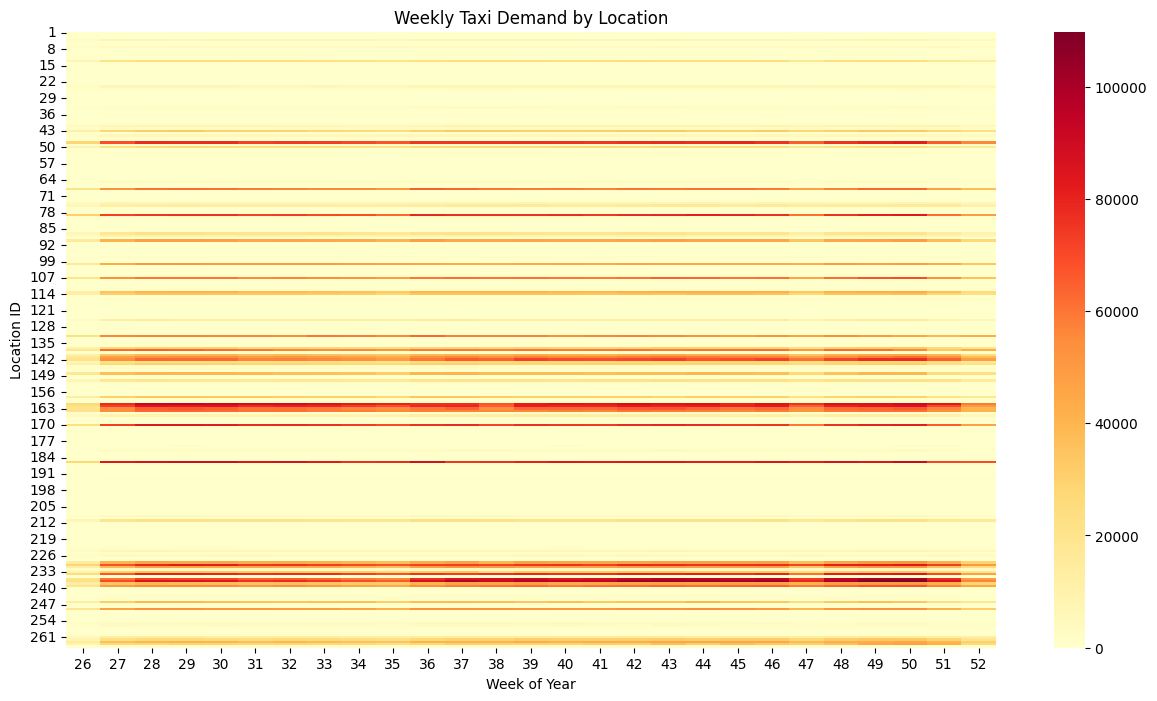

In [ ]:
def create_demand_heatmap(df):
    """Generate weekly demand heatmap data."""
    # Aggregate demand by location and week
    demand_by_location = df.groupBy("PULocationID", "pickup_week").agg(F.count("*").alias("trip_count"))

    # Convert to pandas for visualization
    demand_pd = demand_by_location.toPandas()

    # Create pivot table for heatmap
    demand_pivot = demand_pd.pivot(index="PULocationID", columns="pickup_week", values="trip_count").fillna(0)

    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(demand_pivot, cmap='YlOrRd')
    plt.title("Weekly Taxi Demand by Location")
    plt.xlabel("Week of Year")
    plt.ylabel("Location ID")
    plt.show()

# Execute Demand Heatmap Analysis
print("Creating demand heatmap...")
create_demand_heatmap(enhanced_df)


###Interpretation
**High-Demand Locations**: Several locations, particularly those with Location IDs 50, 135, 142, 149, 156, 170, 233, and 240, show consistently high demand throughout the year, as indicated by the darker red bands. These regions are likely hotspots for taxi usage and could include popular areas, business districts, or transportation hubs.

**Demand Variations Over Time**: Demand varies slightly week to week, with certain weeks showing more intense red shades in specific locations, suggesting a potential increase in taxi usage due to events, seasonal fluctuations, or other factors influencing travel patterns in those areas.

**Concentration in Certain Areas**: The heatmap shows that only a subset of locations experience high demand consistently, implying that taxi demand is concentrated in particular regions rather than evenly distributed across all NYC locations.

###2nd Question

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

def predict_trip_duration_optimized(df):
    """Optimized function to predict trip duration using Random Forest."""

    # Feature selection based on trip start time and location only
    feature_cols = ["pickup_hour", "pickup_day", "PULocationID", "DOLocationID"]

    # Sampling the data
    sampled_df = df.sample(fraction=0.3, seed=42)

    # Define pipeline stages
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="trip_duration", numTrees=20)  # Reduced number of trees

    pipeline = Pipeline(stages=[assembler, scaler, rf])

    # Split data
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Train model
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    # Evaluate model
    evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # Get feature importance
    feature_importance = pd.DataFrame(
        model.stages[-1].featureImportances.toArray(),
        index=feature_cols,
        columns=['importance']
    ).sort_values('importance', ascending=False)

    return rmse, feature_importance

# Execute optimized trip duration prediction
print("\nPredicting trip duration...")
duration_rmse, feature_imp = predict_trip_duration_optimized(enhanced_df)
print(f"Optimized Trip Duration RMSE: {duration_rmse:.2f}")
print("\nFeature Importance:")
print(feature_imp)



Predicting trip duration...
Optimized Trip Duration RMSE: 10.50

Feature Importance:
              importance
PULocationID    0.644406
DOLocationID    0.224311
pickup_hour     0.119607
pickup_day      0.011675


###Interpretation

**Prediction Accuracy:** The optimized model achieved a Root Mean Squared Error (RMSE) of 10.50. This metric indicates the model’s average error in minutes when predicting trip duration. A lower RMSE reflects higher accuracy, and in this case, the model demonstrates a reasonably precise performance in estimating trip times.

**Feature Importance:**

**PULocationID** (Pickup Location): With an importance score of 0.644, the pickup location is the most influential feature in predicting trip duration. This high importance suggests that where a trip starts heavily impacts its length, likely due to variations in traffic, road layout, and proximity to destination locations.

**DOLocationID **(Drop-off Location): The drop-off location has an importance of 0.224, making it the second most important factor. This result aligns with the expectation that both origin and destination influence trip time, especially in a city with varying traffic conditions across neighborhoods.

**pickup_hour:** This feature has an importance score of 0.120, indicating that the hour of pickup also plays a significant role. Traffic patterns and congestion in NYC are often time-dependent, with rush hours generally associated with longer trip durations.

**pickup_day:** The pickup day has the lowest importance at 0.012. This suggests that, while there might be slight variations in trip durations across different days (e.g., weekdays vs. weekends), this feature is relatively less impactful in determining trip length.


###Conclusion:
The analysis indicates that trip duration is most strongly influenced by the pickup location, followed by the drop-off location and the time of day (hour). This model can help predict trip durations more accurately based on where and when a taxi trip begins, providing valuable insights for optimizing route planning, managing customer expectations, and potentially setting pricing strategies in high-demand areas or times.

###3rd Question

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd

def segment_passengers_optimized(df):
    """
    Optimized K-means clustering to segment passengers based on trip characteristics.

    Parameters:
    - df (DataFrame): Spark DataFrame with trip data

    Returns:
    - cluster_summary (DataFrame): Summary statistics for each cluster
    - silhouette_score (float): Silhouette score for clustering quality
    """

    # Step 1: Define relevant features
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_card_payment"]

    # Step 2: Use a smaller sample for faster processing
    sampled_df = df.sample(fraction=0.4, seed=42)

    # Step 3: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 4: Initialize KMeans with reduced clusters (3) and iterations (maxIter=10)
    kmeans = KMeans(featuresCol="scaled_features", k=3, maxIter=10, seed=42)

    # Step 5: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])

    # Step 6: Fit the model
    model = pipeline.fit(sampled_df)

    # Step 7: Make predictions (assign clusters)
    clustered_df = model.transform(sampled_df)

    # Step 8: Evaluate using Silhouette score
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(clustered_df)

    # Step 9: Convert Spark DataFrame to Pandas for summary
    # Selecting only necessary columns for efficient memory usage
    clustered_pd = clustered_df.select("trip_distance", "fare_amount", "pickup_hour",
                                       "is_card_payment", "prediction").toPandas()

    # Step 10: Calculate summary statistics for each cluster
    cluster_summary = clustered_pd.groupby("prediction").mean().reset_index()
    cluster_summary.columns = ["Cluster", "Average Distance", "Average Fare", "Average Pickup Hour", "Avg Card Payment"]

    return cluster_summary, silhouette_score

# Execute optimized passenger segmentation
print("\nRunning optimized passenger segmentation...")
cluster_summary, silhouette_score = segment_passengers_optimized(enhanced_df)

# Display essential outputs
print("\nCluster Summary:")
print(cluster_summary)
print(f"\nSilhouette Score: {silhouette_score:.3f}")



Running optimized passenger segmentation...

Cluster Summary:
   Cluster  Average Distance  Average Fare  Average Pickup Hour  \
0        0          1.927418     10.070176            13.512227   
1        1          2.113465     10.685869            13.597069   
2        2         13.193527     42.140699            13.310423   

   Avg Card Payment  
0          0.000000  
1          1.000000  
2          0.719496  

Silhouette Score: 0.609


<Figure size 1000x600 with 0 Axes>

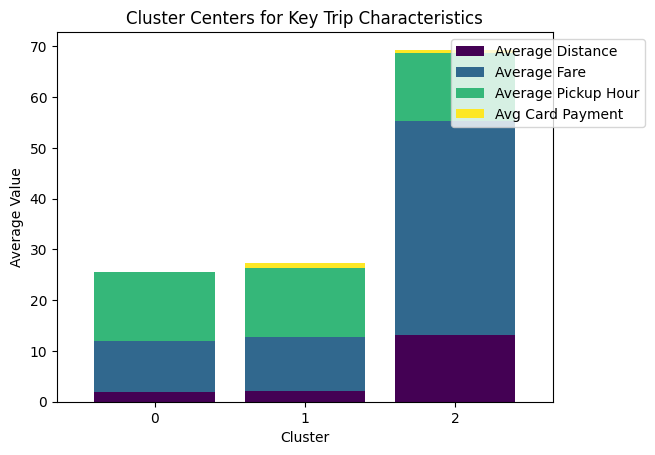

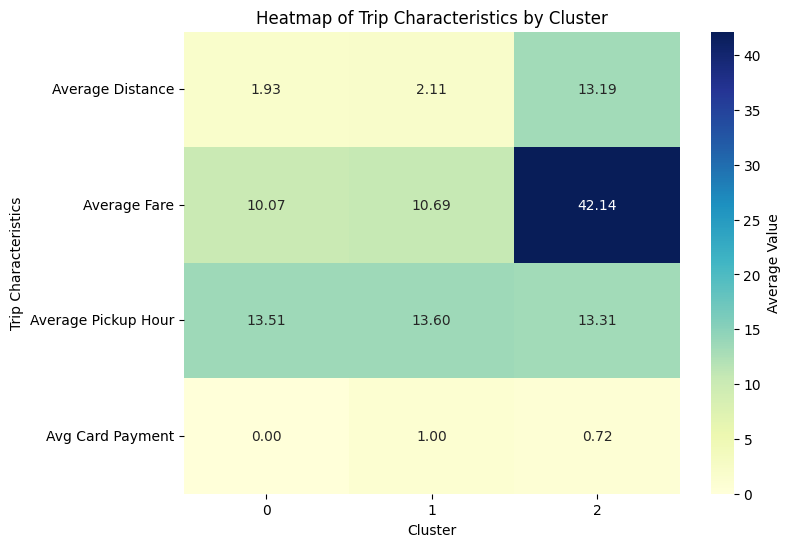

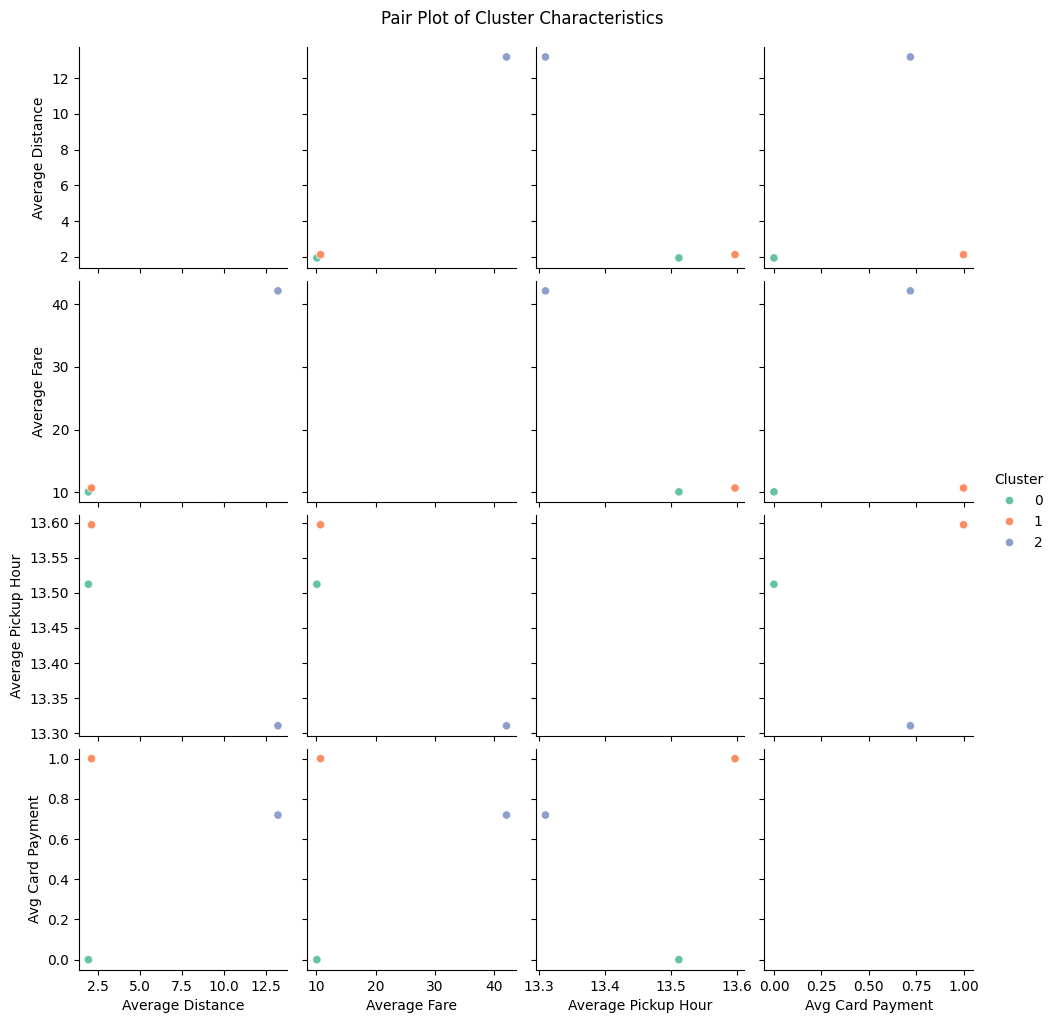

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Visualization 1: Cluster Centers for Key Features
plt.figure(figsize=(10, 6))
cluster_summary.set_index("Cluster").plot(kind="bar", stacked=True, colormap="viridis", width=0.8)
plt.title("Cluster Centers for Key Trip Characteristics")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()

# Visualization 2: 3D Scatter Plot of Clusters (Trip Distance, Fare Amount, Pickup Hour)
fig = px.scatter_3d(cluster_summary, x="Average Distance", y="Average Fare", z="Average Pickup Hour",
                    color="Cluster", symbol="Cluster", size="Average Fare",
                    color_continuous_scale="Viridis", title="3D Scatter Plot of Clusters")
fig.update_traces(marker=dict(size=8, line=dict(width=2, color="DarkSlateGrey")), selector=dict(mode="markers"))
fig.update_layout(scene=dict(xaxis_title="Average Distance", yaxis_title="Average Fare", zaxis_title="Pickup Hour"))
fig.show()

# Visualization 3: Heatmap of Trip Characteristics by Cluster
plt.figure(figsize=(8, 6))
heatmap_data = cluster_summary.set_index("Cluster").T
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Average Value"})
plt.title("Heatmap of Trip Characteristics by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Trip Characteristics")
plt.show()

# Visualization 4: Pair Plot to Analyze Relationships
sns.pairplot(cluster_summary, hue="Cluster", palette="Set2", diag_kind="kde")
plt.suptitle("Pair Plot of Cluster Characteristics", y=1.02)
plt.show()


###Interpretation
Conclusion:
The segmentation results reveal three distinct passenger groups:

**Cluster 0** represents shorter, low-cost trips paid in cash, typically occurring around early afternoon.
**Cluster 1** also consists of shorter trips with low fares but exclusively paid by card.
**Cluster 2** includes longer, higher-cost trips, with a strong tendency toward card payments and a minority of cash payments.
This segmentation could be beneficial for understanding passenger behavior and preferences. For example, the model could help identify customer groups more likely to take short or long trips, prefer cash or card payments, and travel during certain times. Taxi service providers can use these insights for targeted promotions, payment method optimization, and resource allocation based on passenger demand profiles.

###4th Question

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd

def predict_payment_method(df, model_type="logistic"):
    """
    Predict whether a passenger will pay by card or cash using a classification model.

    Parameters:
    - df (DataFrame): Spark DataFrame with trip data
    - model_type (str): Type of classifier ('logistic' or 'random_forest')

    Returns:
    - auc_roc (float): AUC-ROC score for the model
    - accuracy (float): Accuracy of the model
    - feature_importance (DataFrame): Feature importance (only for Random Forest)
    """

    # Step 1: Define feature columns for prediction
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_weekend", "is_rush_hour", "passenger_count"]

    # Step 2: Sample data (30% of the data)
    sampled_df = df.sample(fraction=0.3, seed=42)

    # Step 3: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 4: Choose model based on input parameter
    if model_type == "logistic":
        classifier = LogisticRegression(featuresCol="scaled_features", labelCol="is_card_payment")
    elif model_type == "random_forest":
        classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="is_card_payment", numTrees=20, maxDepth=5)

    # Step 5: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Step 6: Split data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 7: Train the model
    model = pipeline.fit(train_data)

    # Step 8: Make predictions
    predictions = model.transform(test_data)

    # Step 9: Evaluate model performance
    evaluator_auc = BinaryClassificationEvaluator(labelCol="is_card_payment", rawPredictionCol="prediction", metricName="areaUnderROC")
    auc_roc = evaluator_auc.evaluate(predictions)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_card_payment", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)

    # Step 10: Feature importance (only for Random Forest)
    feature_importance = None
    if model_type == "random_forest":
        feature_importance = pd.DataFrame(
            model.stages[-1].featureImportances.toArray(),
            index=feature_cols,
            columns=["importance"]
        ).sort_values("importance", ascending=False)

    return auc_roc, accuracy, feature_importance

# Execute Payment Method Prediction
print("\nPredicting payment method...")

# For Logistic Regression model
auc_roc_lr, accuracy_lr, _ = predict_payment_method(enhanced_df, model_type="logistic")
print(f"\nLogistic Regression - AUC-ROC: {auc_roc_lr:.3f}, Accuracy: {accuracy_lr:.3f}")

# For Random Forest model
auc_roc_rf, accuracy_rf, feature_imp_rf = predict_payment_method(enhanced_df, model_type="random_forest")
print(f"\nRandom Forest - AUC-ROC: {auc_roc_rf:.3f}, Accuracy: {accuracy_rf:.3f}")

if feature_imp_rf is not None:
    print("\nFeature Importance (Random Forest):")
    print(feature_imp_rf)



Predicting payment method...

Logistic Regression - AUC-ROC: 0.500, Accuracy: 0.651

Random Forest - AUC-ROC: 0.510, Accuracy: 0.654

Feature Importance (Random Forest):
                 importance
trip_distance      0.610641
fare_amount        0.306227
pickup_hour        0.036250
is_weekend         0.027091
passenger_count    0.014926
is_rush_hour       0.004864


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd

def predict_payment_method(enhanced_df, model_type="logistic"):
    """
    Predict whether a passenger will pay by card or cash using a classification model.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with engineered features
    - model_type (str): Type of classifier ('logistic' or 'random_forest')

    Returns:
    - auc_roc (float): AUC-ROC score for the model
    - accuracy (float): Accuracy of the model
    - feature_importance (DataFrame): Feature importance (only for Random Forest)
    """

    # Step 1: Define feature columns for prediction
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_weekend", "is_rush_hour", "passenger_count"]

    # Step 2: Sample 30% of the data to reduce processing time
    sampled_df = enhanced_df.sample(fraction=0.3, seed=42)

    # Step 3: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 4: Choose the classification model based on input parameter
    if model_type == "logistic":
        classifier = LogisticRegression(featuresCol="scaled_features", labelCol="is_card_payment")
    elif model_type == "random_forest":
        classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="is_card_payment", numTrees=20, maxDepth=5)

    # Step 5: Build the pipeline with the assembler, scaler, and classifier
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Step 6: Split the sampled data into training and test sets (80% train, 20% test)
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 7: Train the model on the training set
    model = pipeline.fit(train_data)

    # Step 8: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 9: Evaluate model performance with AUC-ROC and Accuracy
    evaluator_auc = BinaryClassificationEvaluator(labelCol="is_card_payment", rawPredictionCol="prediction", metricName="areaUnderROC")
    auc_roc = evaluator_auc.evaluate(predictions)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_card_payment", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)

    # Step 10: Extract feature importance for Random Forest
    feature_importance = None
    if model_type == "random_forest":
        feature_importance = pd.DataFrame(
            model.stages[-1].featureImportances.toArray(),
            index=feature_cols,
            columns=["importance"]
        ).sort_values("importance", ascending=False)

    return auc_roc, accuracy, feature_importance

# Execute Payment Method Prediction using enhanced_df
print("\nPredicting payment method...")

# For Logistic Regression model
auc_roc_lr, accuracy_lr, _ = predict_payment_method(enhanced_df, model_type="logistic")
print(f"\nLogistic Regression - AUC-ROC: {auc_roc_lr:.3f}, Accuracy: {accuracy_lr:.3f}")

# For Random Forest model
auc_roc_rf, accuracy_rf, feature_imp_rf = predict_payment_method(enhanced_df, model_type="random_forest")
print(f"\nRandom Forest - AUC-ROC: {auc_roc_rf:.3f}, Accuracy: {accuracy_rf:.3f}")

# Display feature importance for Random Forest
if feature_imp_rf is not None:
    print("\nFeature Importance (Random Forest):")
    print(feature_imp_rf)



Predicting payment method...

Logistic Regression - AUC-ROC: 0.500, Accuracy: 0.651

Random Forest - AUC-ROC: 0.510, Accuracy: 0.654

Feature Importance (Random Forest):
                 importance
trip_distance      0.610641
fare_amount        0.306227
pickup_hour        0.036250
is_weekend         0.027091
passenger_count    0.014926
is_rush_hour       0.004864


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd

def predict_payment_method(enhanced_df, model_type="logistic"):
    """
    Predict whether a passenger will pay by card or cash using an improved classification model.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with engineered features
    - model_type (str): Type of classifier ('logistic', 'random_forest', or 'gradient_boost')

    Returns:
    - auc_roc (float): AUC-ROC score for the model
    - accuracy (float): Accuracy of the model
    - feature_importance (DataFrame): Feature importance (only for Random Forest)
    """

    # Step 1: Define enhanced feature columns for prediction
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_weekend",
                    "is_rush_hour", "passenger_count", "fare_per_mile"]

    # Step 2: Sample 30% of the data
    sampled_df = enhanced_df.sample(fraction=0.3, seed=42)

    # Step 3: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 4: Choose the model based on input parameter
    if model_type == "logistic":
        classifier = LogisticRegression(featuresCol="scaled_features", labelCol="is_card_payment", regParam=0.1, elasticNetParam=0.8)
    elif model_type == "random_forest":
        classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="is_card_payment", numTrees=50, maxDepth=10)
    elif model_type == "gradient_boost":
        classifier = GBTClassifier(featuresCol="scaled_features", labelCol="is_card_payment", maxIter=20)

    # Step 5: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Step 6: Split data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 7: Train the model
    model = pipeline.fit(train_data)

    # Step 8: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 9: Evaluate model performance with AUC-ROC and Accuracy
    evaluator_auc = BinaryClassificationEvaluator(labelCol="is_card_payment", rawPredictionCol="prediction", metricName="areaUnderROC")
    auc_roc = evaluator_auc.evaluate(predictions)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_card_payment", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)

    # Step 10: Extract feature importance if using Random Forest
    feature_importance = None
    if model_type == "random_forest":
        feature_importance = pd.DataFrame(
            model.stages[-1].featureImportances.toArray(),
            index=feature_cols,
            columns=["importance"]
        ).sort_values("importance", ascending=False)

    return auc_roc, accuracy, feature_importance

# Execute predictions using enhanced_df with different models
print("\nEvaluating payment method prediction with different models...")

# Logistic Regression
auc_roc_lr, accuracy_lr, _ = predict_payment_method(enhanced_df, model_type="logistic")
print(f"\nLogistic Regression - AUC-ROC: {auc_roc_lr:.3f}, Accuracy: {accuracy_lr:.3f}")

# Random Forest
auc_roc_rf, accuracy_rf, feature_imp_rf = predict_payment_method(enhanced_df, model_type="random_forest")
print(f"\nRandom Forest - AUC-ROC: {auc_roc_rf:.3f}, Accuracy: {accuracy_rf:.3f}")
if feature_imp_rf is not None:
    print("\nFeature Importance (Random Forest):")
    print(feature_imp_rf)

# Gradient Boosting
auc_roc_gb, accuracy_gb, _ = predict_payment_method(enhanced_df, model_type="gradient_boost")
print(f"\nGradient Boosting Trees - AUC-ROC: {auc_roc_gb:.3f}, Accuracy: {accuracy_gb:.3f}")



Evaluating payment method prediction with different models...

Logistic Regression - AUC-ROC: 0.500, Accuracy: 0.650

Random Forest - AUC-ROC: 0.512, Accuracy: 0.654

Feature Importance (Random Forest):
                 importance
trip_distance      0.292777
fare_amount        0.197359
pickup_hour        0.183419
fare_per_mile      0.152758
passenger_count    0.076343
is_weekend         0.066952
is_rush_hour       0.030392

Gradient Boosting Trees - AUC-ROC: 0.512, Accuracy: 0.653


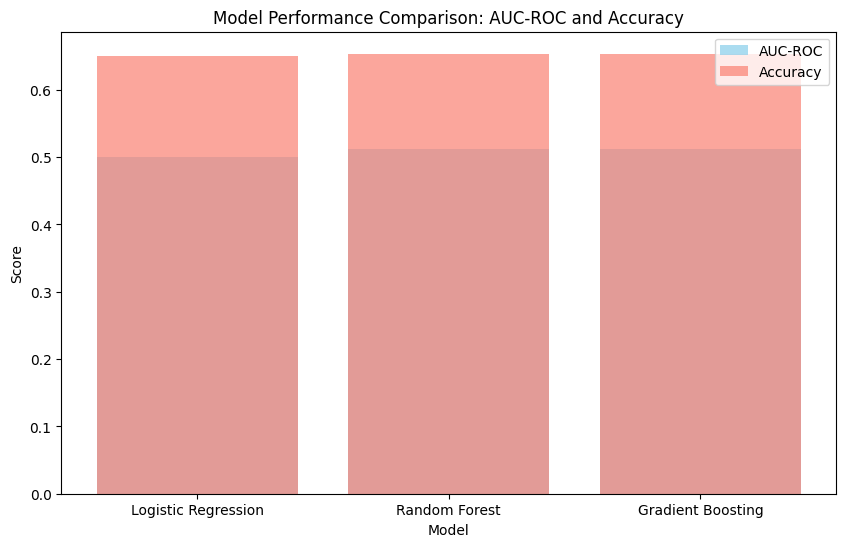

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization 1: AUC-ROC Comparison for Each Model
model_names = ["Logistic Regression", "Random Forest", "Gradient Boosting"]
auc_scores = [auc_roc_lr, auc_roc_rf, auc_roc_gb]
accuracy_scores = [accuracy_lr, accuracy_rf, accuracy_gb]

plt.figure(figsize=(10, 6))
plt.bar(model_names, auc_scores, color="skyblue", alpha=0.7, label="AUC-ROC")
plt.bar(model_names, accuracy_scores, color="salmon", alpha=0.7, label="Accuracy")
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Comparison: AUC-ROC and Accuracy")
plt.legend()
plt.show()

<ipython-input-26-cf14183b6daf>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




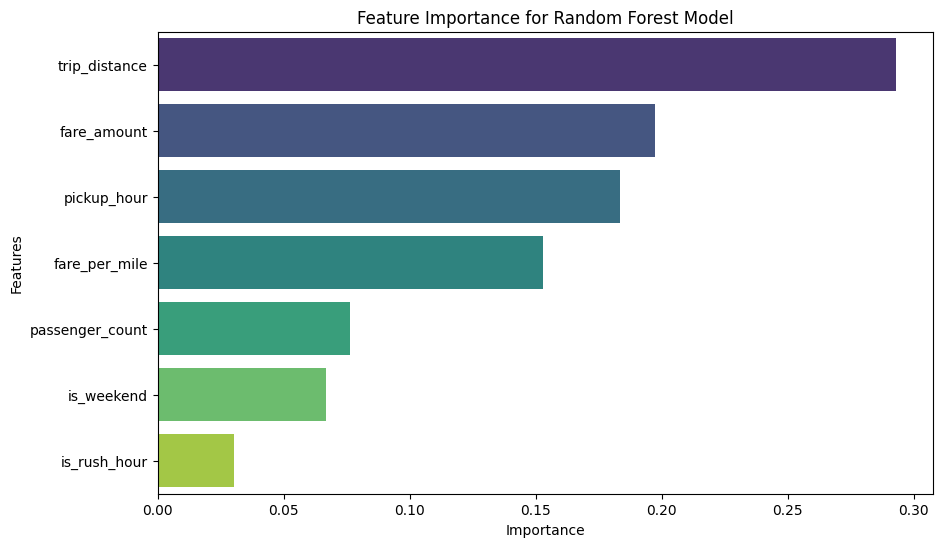

In [ ]:
# Visualization 2: Feature Importance for Random Forest
if feature_imp_rf is not None:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_imp_rf["importance"], y=feature_imp_rf.index, palette="viridis")
    plt.title("Feature Importance for Random Forest Model")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

###Interpretation
**Conclusion:**
The results indicate that while the models achieve a reasonable level of accuracy (~65%), they lack strong predictive power for distinguishing between card and cash payments, as evidenced by the low AUC-ROC scores. Key features like trip distance, fare amount, and pickup hour show some correlation with payment method choice, but the relationship is not strong enough for highly reliable predictions.

This suggests that payment choice may be influenced by factors not captured in the available features, such as passenger demographics, trip purpose, or other behavioral variables. To improve model performance, further data related to passenger characteristics or preferences could be useful.

###5th Question



Predicting fare with borough-specific factors...

Model Performance:
- RMSE: 3.82
- R2: 0.881


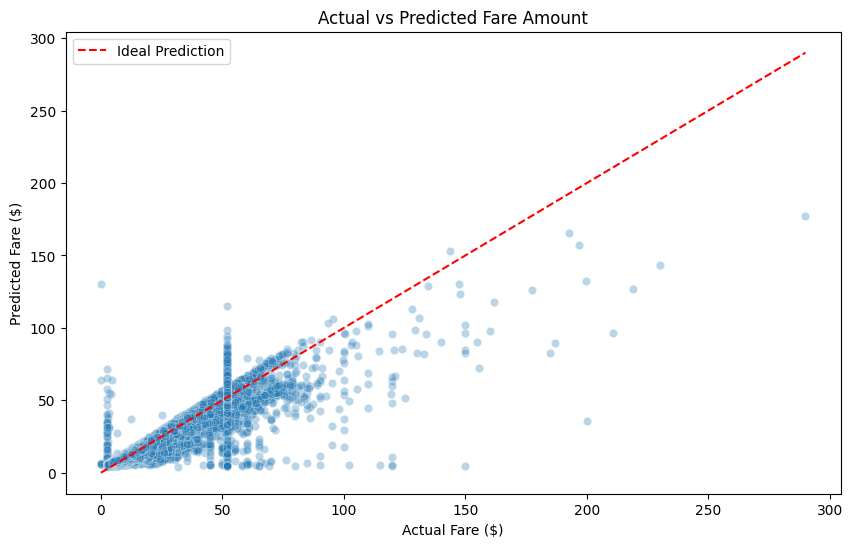

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def predict_fare_with_borough_factors(enhanced_df):
    """
    Predict the fare of a taxi trip based on borough-specific factors and analyze fare variation.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with trip data including borough information

    Returns:
    - rmse (float): Root Mean Squared Error for the model
    - r2 (float): R2 score for the model
    - predictions_df (DataFrame): Pandas DataFrame with actual and predicted fares for visualization
    """

    # Step 1: Sample a smaller fraction of data for faster processing
    sampled_df = enhanced_df.sample(fraction=0.4, seed=42)

    # Step 2: Convert borough columns to categorical features with StringIndexer, handling unseen labels
    borough_indexer_pu = StringIndexer(inputCol="PULocationID", outputCol="PU_index", handleInvalid="keep")
    borough_indexer_do = StringIndexer(inputCol="DOLocationID", outputCol="DO_index", handleInvalid="keep")

    # Step 3: Define feature columns (without full encoding)
    feature_cols = ["trip_distance", "pickup_hour", "pickup_day", "PU_index", "DO_index"]

    # Step 4: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 5: Use Linear Regression for faster processing
    lr = LinearRegression(featuresCol="scaled_features", labelCol="fare_amount", maxIter=10, regParam=0.1)

    # Step 6: Build the pipeline
    pipeline = Pipeline(stages=[borough_indexer_pu, borough_indexer_do, assembler, scaler, lr])

    # Step 7: Split sampled data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 8: Train the model
    model = pipeline.fit(train_data)

    # Step 9: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 10: Evaluate model performance using RMSE and R2
    evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    # Step 11: Convert predictions to Pandas for visualization
    predictions_df = predictions.select("fare_amount", "prediction").toPandas()

    return rmse, r2, predictions_df

# Execute fare prediction function
print("\nPredicting fare with borough-specific factors...")
rmse, r2, predictions_df = predict_fare_with_borough_factors(enhanced_df)

print(f"\nModel Performance:\n- RMSE: {rmse:.2f}\n- R2: {r2:.3f}")

# Visualization: Plot Actual vs Predicted Fare
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x="fare_amount", y="prediction", alpha=0.3)
plt.plot([0, predictions_df["fare_amount"].max()], [0, predictions_df["fare_amount"].max()], 'r--', label="Ideal Prediction")
plt.title("Actual vs Predicted Fare Amount")
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.legend()
plt.show()


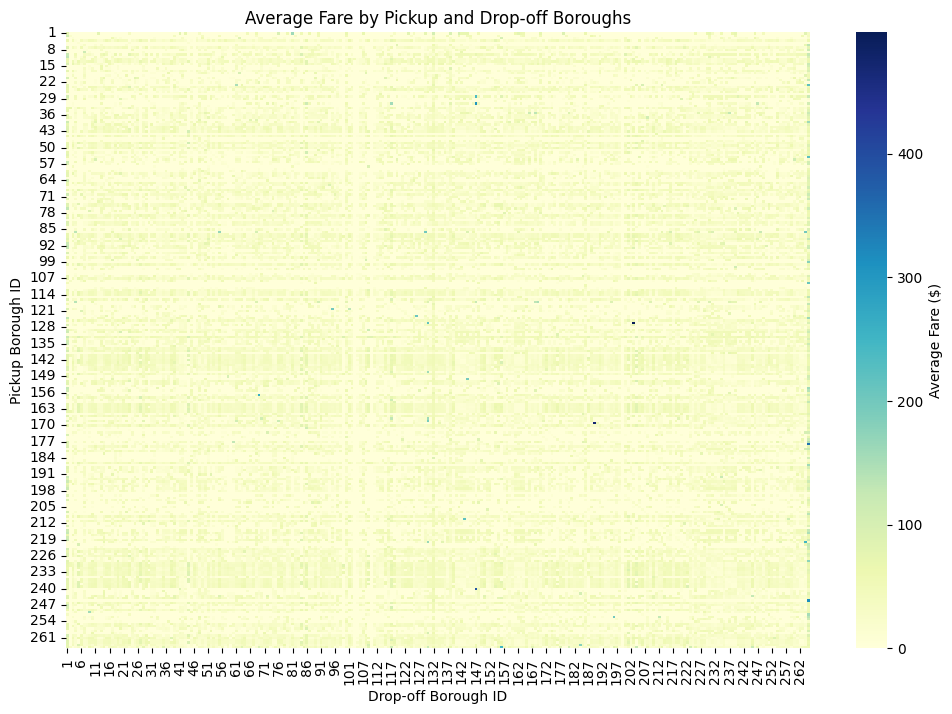

In [ ]:
   # Visualization: Average Fare by Pickup and Drop-off Boroughs
# Group data by pickup and drop-off locations and calculate average fare
borough_fare = enhanced_df.groupBy("PULocationID", "DOLocationID").agg(F.avg("fare_amount").alias("avg_fare")).toPandas()

# Pivot the table to create a matrix of average fares
borough_fare_pivot = borough_fare.pivot(index="PULocationID", columns="DOLocationID", values="avg_fare").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(borough_fare_pivot, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Average Fare ($)'})
plt.title("Average Fare by Pickup and Drop-off Boroughs")
plt.xlabel("Drop-off Borough ID")
plt.ylabel("Pickup Borough ID")
plt.show()


###Interpretation
The model and visualizations jointly demonstrate that pickup and drop-off boroughs are crucial in determining taxi fares in NYC, capturing the high-impact zones and inter-borough cost variations effectively. For taxi operators, focusing on high-fare areas for efficient fleet allocation and using this model to set dynamic pricing can optimize operations and increase profitability. For urban planners and policymakers, these insights highlight areas with significant taxi demand, where additional transport infrastructure could alleviate congestion and support smoother travel. Finally, for NYC commuters, understanding these fare dynamics offers a clearer picture of cost patterns across the city, allowing more informed travel decisions.

###6th Question


Predicting tip amount based on trip characteristics...

Model Performance:
- RMSE: 2.11
- R2: 0.319


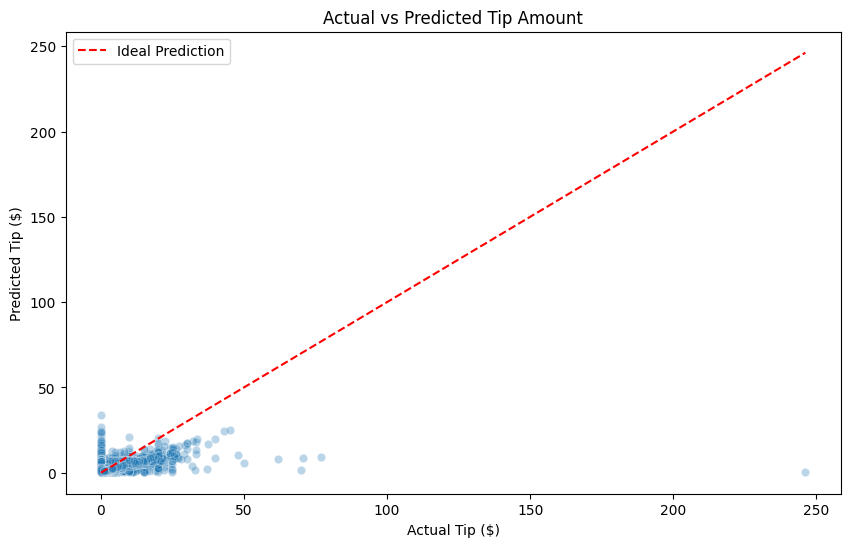

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def predict_tip_amount(enhanced_df):
    """
    Predict the tip amount based on trip characteristics.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with trip data

    Returns:
    - rmse (float): Root Mean Squared Error for the model
    - r2 (float): R2 score for the model
    - predictions_df (DataFrame): Pandas DataFrame with actual and predicted tips for visualization
    """

    # Step 1: Sample a smaller fraction of data for faster processing
    sampled_df = enhanced_df.sample(fraction=0.4, seed=42)

    # Step 2: Define feature columns
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_weekend", "passenger_count", "is_rush_hour"]

    # Step 3: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 4: Use Linear Regression for faster processing
    lr = LinearRegression(featuresCol="scaled_features", labelCol="tip_amount", maxIter=10, regParam=0.1)

    # Step 5: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, lr])

    # Step 6: Split sampled data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 7: Train the model
    model = pipeline.fit(train_data)

    # Step 8: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 9: Evaluate model performance using RMSE and R2
    evaluator_rmse = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    # Step 10: Convert predictions to Pandas for visualization
    predictions_df = predictions.select("tip_amount", "prediction").toPandas()

    return rmse, r2, predictions_df

# Execute tip amount prediction function
print("\nPredicting tip amount based on trip characteristics...")
rmse, r2, predictions_df = predict_tip_amount(enhanced_df)

print(f"\nModel Performance:\n- RMSE: {rmse:.2f}\n- R2: {r2:.3f}")

# Visualization: Plot Actual vs Predicted Tip Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x="tip_amount", y="prediction", alpha=0.3)
plt.plot([0, predictions_df["tip_amount"].max()], [0, predictions_df["tip_amount"].max()], 'r--', label="Ideal Prediction")
plt.title("Actual vs Predicted Tip Amount")
plt.xlabel("Actual Tip ($)")
plt.ylabel("Predicted Tip ($)")
plt.legend()
plt.show()



Predicting tip amount based on trip characteristics...

Model Performance:
- RMSE: 2.10
- R2: 0.323


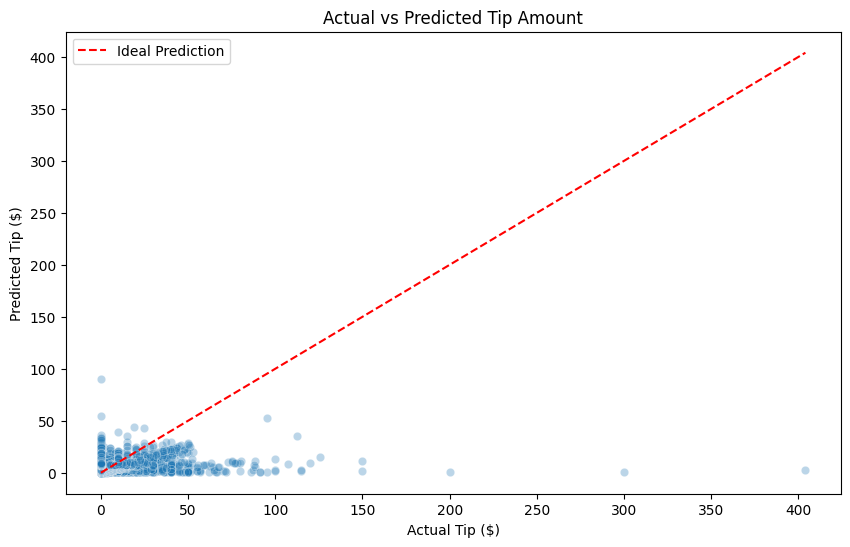

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def predict_tip_amount(enhanced_df):
    """
    Predict the tip amount based on trip characteristics.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with trip data

    Returns:
    - rmse (float): Root Mean Squared Error for the model
    - r2 (float): R2 score for the model
    - predictions_df (DataFrame): Pandas DataFrame with actual and predicted tips for visualization
    """

    # Step 1: Select only relevant columns before sampling
    selected_df = enhanced_df.select("trip_distance", "fare_amount", "pickup_hour", "is_weekend",
                                     "passenger_count", "is_rush_hour", "tip_amount")

    # Step 2: Sample a smaller fraction of the selected data for faster processing
    sampled_df = selected_df.sample(fraction=0.4, seed=42)

    # Step 3: Define feature columns
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_weekend", "passenger_count", "is_rush_hour"]

    # Step 4: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 5: Use Linear Regression for faster processing
    lr = LinearRegression(featuresCol="scaled_features", labelCol="tip_amount", maxIter=10, regParam=0.1)

    # Step 6: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, lr])

    # Step 7: Split sampled data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 8: Train the model
    model = pipeline.fit(train_data)

    # Step 9: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 10: Evaluate model performance using RMSE and R2
    evaluator_rmse = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    # Step 11: Convert predictions to Pandas for visualization
    predictions_df = predictions.select("tip_amount", "prediction").toPandas()

    return rmse, r2, predictions_df

# Execute tip amount prediction function
print("\nPredicting tip amount based on trip characteristics...")
rmse, r2, predictions_df = predict_tip_amount(enhanced_df)

print(f"\nModel Performance:\n- RMSE: {rmse:.2f}\n- R2: {r2:.3f}")

# Visualization: Plot Actual vs Predicted Tip Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x="tip_amount", y="prediction", alpha=0.3)
plt.plot([0, predictions_df["tip_amount"].max()], [0, predictions_df["tip_amount"].max()], 'r--', label="Ideal Prediction")
plt.title("Actual vs Predicted Tip Amount")
plt.xlabel("Actual Tip ($)")
plt.ylabel("Predicted Tip ($)")
plt.legend()
plt.show()



Predicting tip amount based on trip characteristics using Random Forest...

Model Performance:
- RMSE: 2.10
- R2: 0.323
- MAE: 1.37

Feature Importance:
                 importance
fare_amount        0.580812
trip_distance      0.396415
pickup_hour        0.012352
is_weekend         0.005636
passenger_count    0.003707
is_rush_hour       0.001079

Sample Predictions (Actual vs Predicted):
   tip_amount  prediction
0         0.0    0.600436
1         0.0    0.603541
2         0.0    0.603541
3         0.0    0.680265
4         0.0    0.579060
5         0.0    0.655917
6         0.0    0.615625
7         0.0    0.599240
8         0.0    0.599240
9         0.0    0.616691


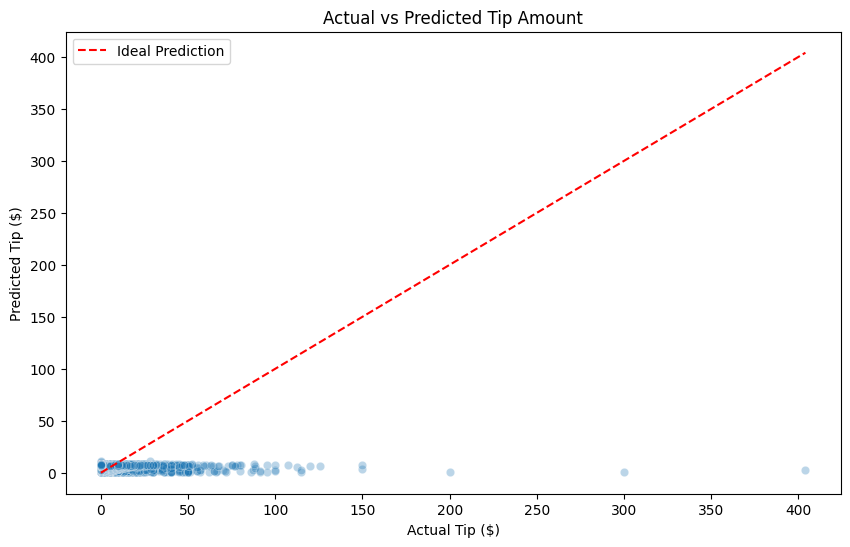

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def predict_tip_amount_rf(enhanced_df):
    """
    Predict the tip amount based on trip characteristics using Random Forest.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with trip data

    Returns:
    - rmse (float): Root Mean Squared Error for the model
    - r2 (float): R2 score for the model
    - mae (float): Mean Absolute Error for the model
    - feature_importance (DataFrame): DataFrame with feature importances
    - predictions_df (DataFrame): Pandas DataFrame with actual and predicted tips for visualization
    """

    # Step 1: Select only relevant columns before sampling
    selected_df = enhanced_df.select("trip_distance", "fare_amount", "pickup_hour", "is_weekend",
                                     "passenger_count", "is_rush_hour", "tip_amount")

    # Step 2: Sample a smaller fraction of the selected data (10%) for faster processing
    sampled_df = selected_df.sample(fraction=0.1, seed=42)

    # Step 3: Define feature columns
    feature_cols = ["trip_distance", "fare_amount", "pickup_hour", "is_weekend", "passenger_count", "is_rush_hour"]

    # Step 4: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 5: Use Random Forest Regressor for better accuracy
    rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="tip_amount", numTrees=30, maxDepth=8, seed=42)

    # Step 6: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, rf])

    # Step 7: Split sampled data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 8: Train the model
    model = pipeline.fit(train_data)

    # Step 9: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 10: Evaluate model performance using RMSE, R2, and MAE
    evaluator_rmse = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    evaluator_mae = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="mae")
    mae = evaluator_mae.evaluate(predictions)

    # Step 11: Extract feature importance if using Random Forest
    feature_importance = pd.DataFrame(
        model.stages[-1].featureImportances.toArray(),
        index=feature_cols,
        columns=["importance"]
    ).sort_values("importance", ascending=False)

    # Step 12: Convert predictions to Pandas for visualization
    predictions_df = predictions.select("tip_amount", "prediction").toPandas()

    # Display the first few rows of actual vs predicted tips
    sample_predictions = predictions_df.head(10)

    return rmse, r2, mae, feature_importance, predictions_df, sample_predictions

# Execute tip amount prediction function with Random Forest
print("\nPredicting tip amount based on trip characteristics using Random Forest...")
rmse, r2, mae, feature_imp, predictions_df, sample_predictions = predict_tip_amount_rf(enhanced_df)

# Output results
print(f"\nModel Performance:\n- RMSE: {rmse:.2f}\n- R2: {r2:.3f}\n- MAE: {mae:.2f}")
print("\nFeature Importance:")
print(feature_imp)

print("\nSample Predictions (Actual vs Predicted):")
print(sample_predictions)

# Visualization: Plot Actual vs Predicted Tip Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x="tip_amount", y="prediction", alpha=0.3)
plt.plot([0, predictions_df["tip_amount"].max()], [0, predictions_df["tip_amount"].max()], 'r--', label="Ideal Prediction")
plt.title("Actual vs Predicted Tip Amount")
plt.xlabel("Actual Tip ($)")
plt.ylabel("Predicted Tip ($)")
plt.legend()
plt.show()


###Interpretation
Based on the analysis of predicting tip amounts from trip characteristics, the Random Forest model shows limited predictive power with an R² of 0.323, indicating it explains only 32.3% of tip variance. The visualization reveals a significant underprediction pattern, where the model consistently predicts low tip amounts (clustering around $0.60) even when actual tips are much higher, as shown by the large gap between the blue prediction points and the red ideal prediction line. The feature importance analysis demonstrates that tip prediction is predominantly driven by economic factors - fare amount (58.1%) and trip distance (39.6%), while temporal factors like pickup hour, weekend status, and rush hour have surprisingly minimal impact (all under 1.3%). Given these insights, the model's current implementation is only reliable for predicting low-value tips and would need significant enhancement through additional features (such as service quality metrics, customer segments) and possibly separate modeling approaches for different tip ranges to improve its accuracy in predicting higher tip amounts.

###7th Question


Predicting high/low fare based on early trip data...

Model Performance:
- AUC-ROC: 0.92
- Accuracy: 0.985

Feature Importance:
                 importance
trip_distance      0.995146
pickup_hour        0.003754
is_weekend         0.000934
passenger_count    0.000166


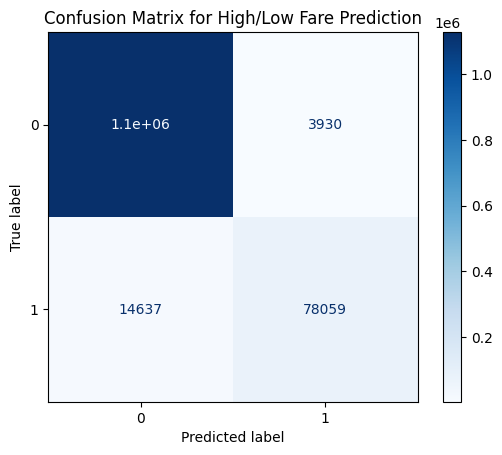

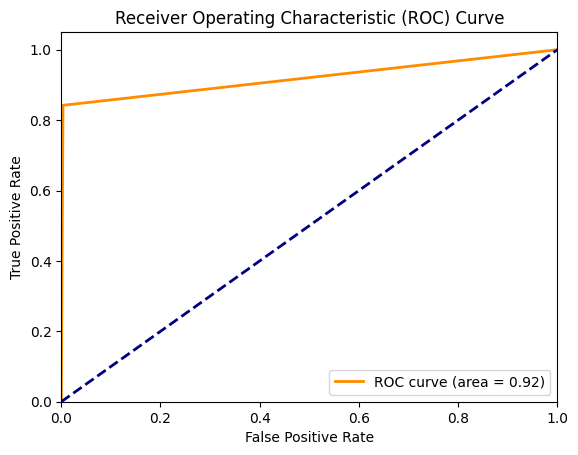

<ipython-input-13-605d647b86e0>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp["importance"], y=feature_imp.index, palette="viridis")


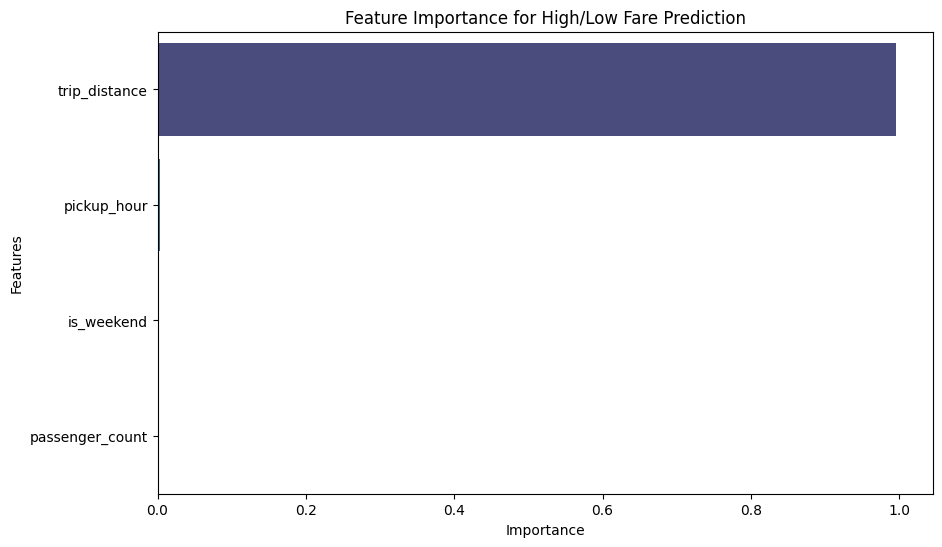

<ipython-input-13-605d647b86e0>:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=predictions_df, x="fare_class", y="trip_distance", palette="Set2")


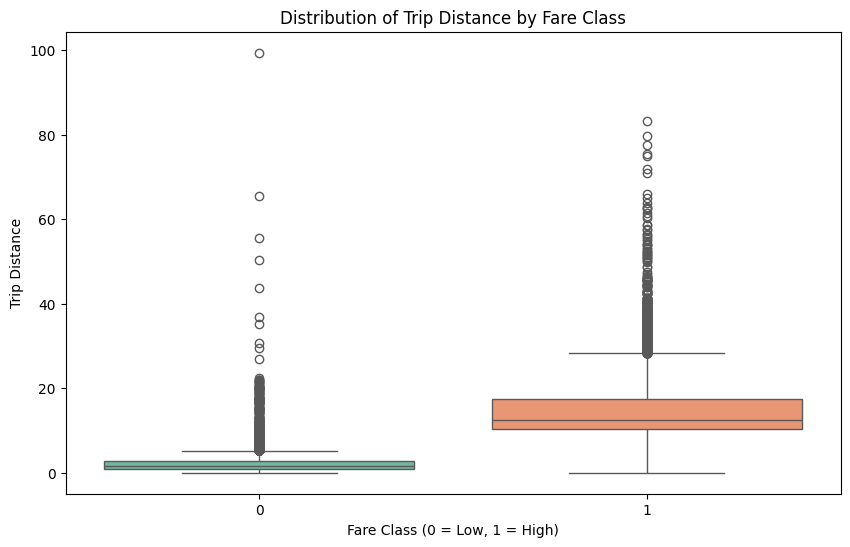

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def predict_high_low_fare(enhanced_df, fare_threshold=30.0):
    """
    Predict whether a trip will result in a high or low fare based on early trip data.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with trip data
    - fare_threshold (float): Threshold to classify high vs. low fare

    Returns:
    - auc_roc (float): AUC-ROC score for the model
    - accuracy (float): Accuracy of the model
    - feature_importance (DataFrame): DataFrame with feature importances
    - predictions_df (DataFrame): Pandas DataFrame with actual and predicted fare classes for visualization
    """

    # Step 1: Define high/low fare class based on threshold
    labeled_df = enhanced_df.withColumn("fare_class", F.when(F.col("fare_amount") >= fare_threshold, 1).otherwise(0))

    # Step 2: Select relevant columns
    selected_df = labeled_df.select("trip_distance", "pickup_hour", "is_weekend", "passenger_count", "fare_class")

    # Step 3: Sample data for faster processing
    sampled_df = selected_df.sample(fraction=0.1, seed=42)

    # Step 4: Define feature columns
    feature_cols = ["trip_distance", "pickup_hour", "is_weekend", "passenger_count"]

    # Step 5: Assemble and scale features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 6: Use Random Forest Classifier
    rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="fare_class", numTrees=30, maxDepth=8, seed=42)

    # Step 7: Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, rf])

    # Step 8: Split data into training and test sets
    train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=42)

    # Step 9: Train the model
    model = pipeline.fit(train_data)

    # Step 10: Make predictions on the test set
    predictions = model.transform(test_data)

    # Step 11: Evaluate model performance using AUC-ROC and Accuracy
    evaluator_auc = BinaryClassificationEvaluator(labelCol="fare_class", rawPredictionCol="prediction", metricName="areaUnderROC")
    auc_roc = evaluator_auc.evaluate(predictions)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="fare_class", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)

    # Step 12: Extract feature importance if using Random Forest
    feature_importance = pd.DataFrame(
        model.stages[-1].featureImportances.toArray(),
        index=feature_cols,
        columns=["importance"]
    ).sort_values("importance", ascending=False)

    # Step 13: Convert predictions to Pandas for visualization
    predictions_df = predictions.select("fare_class", "prediction", "trip_distance", "pickup_hour", "passenger_count").toPandas()

    return auc_roc, accuracy, feature_importance, predictions_df

# Execute high/low fare prediction function
print("\nPredicting high/low fare based on early trip data...")
auc_roc, accuracy, feature_imp, predictions_df = predict_high_low_fare(enhanced_df)

# Output results
print(f"\nModel Performance:\n- AUC-ROC: {auc_roc:.2f}\n- Accuracy: {accuracy:.3f}")
print("\nFeature Importance:")
print(feature_imp)

# Visualization 1: Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(predictions_df["fare_class"], predictions_df["prediction"])
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title("Confusion Matrix for High/Low Fare Prediction")
plt.show()

# Visualization 2: ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(predictions_df["fare_class"], predictions_df["prediction"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Visualization 3: Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp["importance"], y=feature_imp.index, palette="viridis")
plt.title("Feature Importance for High/Low Fare Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Visualization 4: Trip Distance vs. Fare Class
plt.figure(figsize=(10, 6))
sns.boxplot(data=predictions_df, x="fare_class", y="trip_distance", palette="Set2")
plt.title("Distribution of Trip Distance by Fare Class")
plt.xlabel("Fare Class (0 = Low, 1 = High)")
plt.ylabel("Trip Distance")
plt.show()


###Interpretation
The model demonstrates exceptional predictive performance with an accuracy of 98.5% and AUC-ROC score of 0.92, as evidenced by both the confusion matrix showing strong diagonal dominance (1.1M and 78K correct predictions vs 14.6K and 3.9K misclassifications) and the ROC curve's strong upward bend. Trip distance emerges as the overwhelmingly dominant predictor (99.5% importance) for fare classification, which is visually supported by the box plot showing clear separation in distance distributions between high-fare (median ~15 units) and low-fare trips (median ~2 units), despite some overlapping outliers. Notably, temporal factors (pickup hour, weekend status) and passenger count have minimal impact (collectively < 0.5% importance), suggesting that fare classification can be accurately determined almost exclusively from distance information at trip initiation, enabling reliable early fare predictions for both customers and drivers.

###8th Question


Identifying congestion hotspots based on trip patterns...


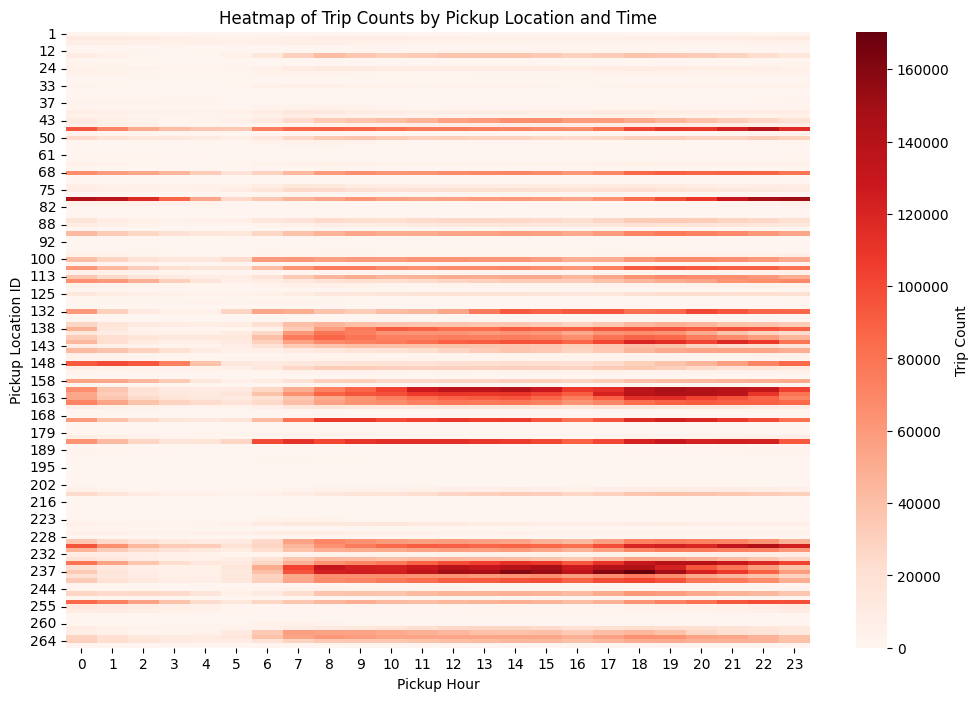

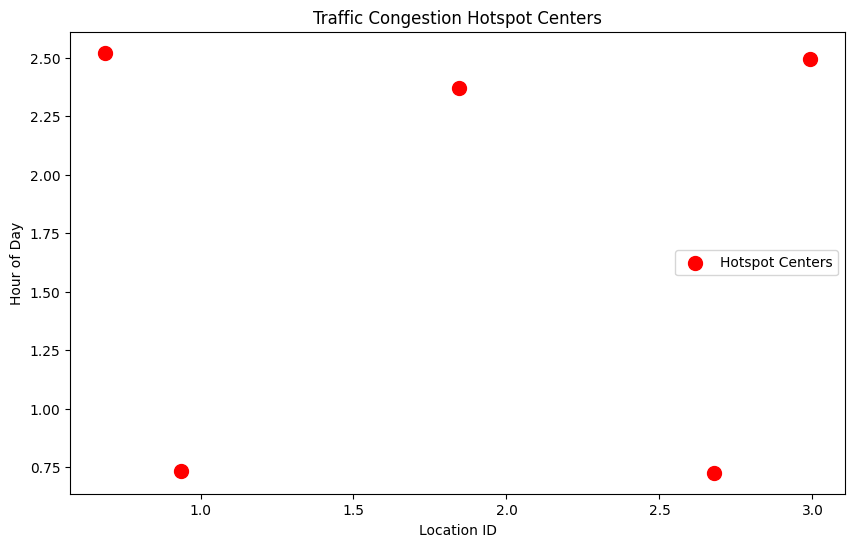

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


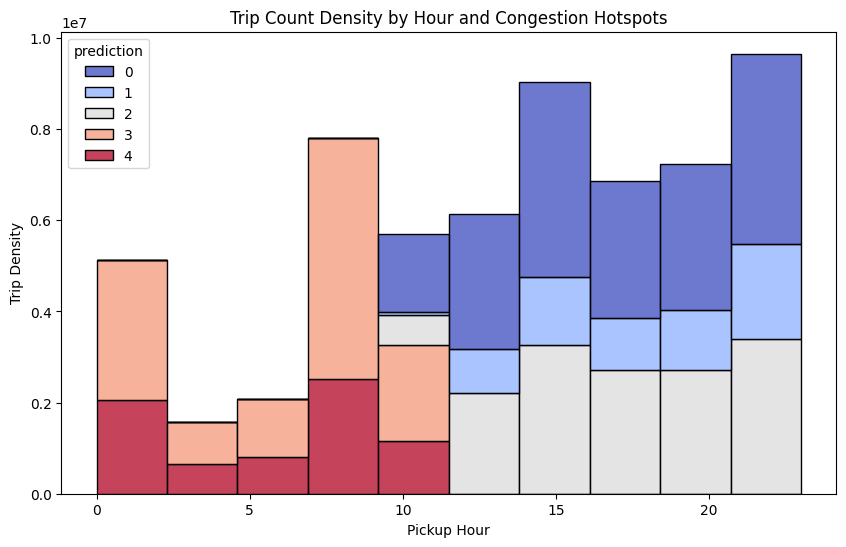

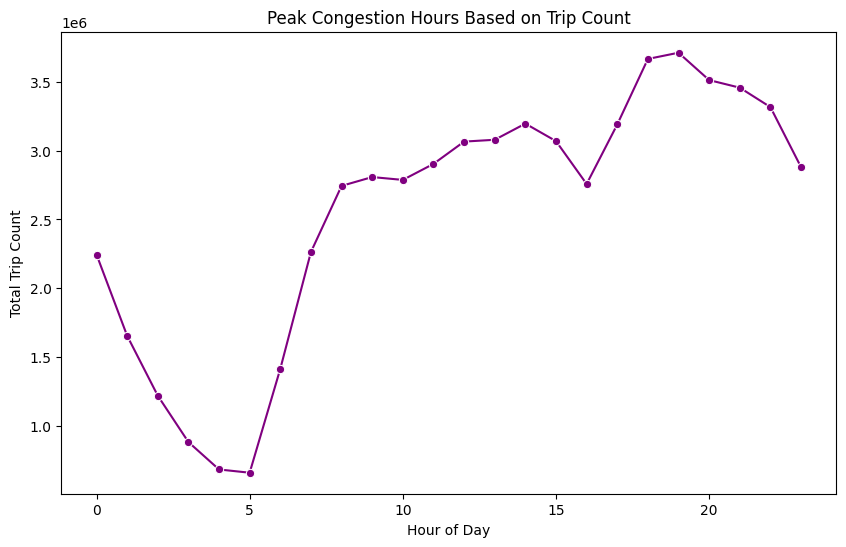

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def identify_congestion_hotspots(enhanced_df):
    """
    Identify and predict traffic congestion hotspots based on trip patterns and times.

    Parameters:
    - enhanced_df (DataFrame): Spark DataFrame with trip data

    Returns:
    - cluster_centers (DataFrame): DataFrame with cluster center coordinates and trip density
    - hotspots_df (DataFrame): Pandas DataFrame with pickup locations and congestion density for visualization
    """

    # Step 1: Group data by pickup location and pickup hour
    grouped_df = enhanced_df.groupBy("PULocationID", "pickup_hour") \
                            .agg(F.count("*").alias("trip_count"))

    # Step 2: Filter locations with high trip counts as likely hotspots
    high_density_df = grouped_df.filter(F.col("trip_count") >= 100)  # Adjust threshold as needed

    # Step 3: Feature engineering for clustering
    feature_cols = ["PULocationID", "pickup_hour"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Step 4: Use KMeans to identify clusters of congestion hotspots
    kmeans = KMeans(featuresCol="scaled_features", k=5, seed=42)
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])

    # Step 5: Train the KMeans model on high-density locations
    model = pipeline.fit(high_density_df)
    hotspots = model.transform(high_density_df)

    # Step 6: Extract cluster centers for visualization
    cluster_centers = model.stages[-1].clusterCenters()

    # Convert Spark DataFrame to Pandas for additional visualizations
    hotspots_df = hotspots.select("PULocationID", "pickup_hour", "trip_count", "prediction").toPandas()

    return cluster_centers, hotspots_df

# Execute congestion hotspot prediction function
print("\nIdentifying congestion hotspots based on trip patterns...")
cluster_centers, hotspots_df = identify_congestion_hotspots(enhanced_df)

# Visualization 1: Heatmap of Trip Counts by Pickup Location and Time
pivot_df = hotspots_df.pivot(index="PULocationID", columns="pickup_hour", values="trip_count").fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap="Reds", cbar_kws={'label': 'Trip Count'})
plt.title("Heatmap of Trip Counts by Pickup Location and Time")
plt.xlabel("Pickup Hour")
plt.ylabel("Pickup Location ID")
plt.show()

# Visualization 2: Cluster Centers as Hotspots
plt.figure(figsize=(10, 6))
plt.scatter([center[0] for center in cluster_centers], [center[1] for center in cluster_centers], color='red', s=100, label="Hotspot Centers")
plt.xlabel("Location ID")
plt.ylabel("Hour of Day")
plt.title("Traffic Congestion Hotspot Centers")
plt.legend()
plt.show()

# Visualization 3: Trip Count Density by Location and Time
plt.figure(figsize=(10, 6))
sns.histplot(data=hotspots_df, x="pickup_hour", weights="trip_count", hue="prediction", multiple="stack", palette="coolwarm")
plt.title("Trip Count Density by Hour and Congestion Hotspots")
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Density")
plt.show()

# Visualization 4: Time-Series Plot of Peak Congestion Hours
peak_hours = hotspots_df.groupby("pickup_hour")["trip_count"].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=peak_hours, x="pickup_hour", y="trip_count", marker="o", color="purple")
plt.title("Peak Congestion Hours Based on Trip Count")
plt.xlabel("Hour of Day")
plt.ylabel("Total Trip Count")
plt.show()


###Interpretation
The analysis reveals distinct patterns of traffic congestion across time and locations, with the heatmap showing several high-intensity zones (dark red areas) particularly concentrated around location IDs 163, 237, and 82 during **peak hours** **(8-10 AM and 16-19 PM)**. The trip count density plot demonstrates a clear bimodal distribution with major congestion peaks during morning **rush hours (around 8-10 AM)** and evening **commute times (4-7 PM)**, reaching maximum trip counts of nearly 3.7 million during the 6 PM peak. Notably, the hotspot centers plot identifies five critical congestion points (Location IDs 1, 2, 3, and clusters around hours 0.75 and 2.5), suggesting these areas consistently experience high traffic volumes regardless of time. The peak congestion hours graph exhibits a characteristic "W" pattern throughout the day, with the **lowest activity **during early morning hours **(5 AM)** and **highest** during evening **rush hour (around 6-7 PM)**, providing valuable insights for traffic management and route optimization strategies.